CIFAR10
=========

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

  -  GPU 설정

In [36]:
# GPU가 실행되면 True를 반환
torch.cuda.is_available()

True

In [37]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else 'cpu')

전처리 설정

In [38]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

데이터 로드 및 확인

In [39]:
trainset = torchvision.datasets.CIFAR10(root='./_data',
                                        train=True,
                                        download=True,
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='./_data',
                                        train=False,
                                        download=True,
                                        transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
train_loader = DataLoader(trainset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=2)

In [41]:
# CIFAR10의 클래스를 정의
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'flog', 'horse', 'ship', 'truck')

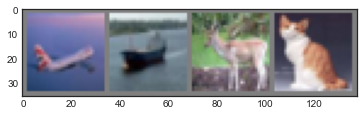

	plane 	ship 	deer 	cat


In [42]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

신경망 구성

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to(device)

손실함수와 옵티마이저

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

모델 학습

In [45]:
for epoch in range(5):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch : {}, Batch : {}, Loss : {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch : 1, Batch : 2000, Loss : 2.258272805571556
Epoch : 1, Batch : 4000, Loss : 1.899998623251915
Epoch : 1, Batch : 6000, Loss : 1.6979643231034278
Epoch : 1, Batch : 8000, Loss : 1.5854025471657514
Epoch : 1, Batch : 10000, Loss : 1.5350745584517718
Epoch : 1, Batch : 12000, Loss : 1.4740100513622165
Epoch : 2, Batch : 2000, Loss : 1.4176577547714113
Epoch : 2, Batch : 4000, Loss : 1.3867793614938855
Epoch : 2, Batch : 6000, Loss : 1.3529402123764158
Epoch : 2, Batch : 8000, Loss : 1.3381955439075828
Epoch : 2, Batch : 10000, Loss : 1.3347090910971164
Epoch : 2, Batch : 12000, Loss : 1.3046714412122964
Epoch : 3, Batch : 2000, Loss : 1.25207327722013
Epoch : 3, Batch : 4000, Loss : 1.2292894919663668
Epoch : 3, Batch : 6000, Loss : 1.2281258675344289
Epoch : 3, Batch : 8000, Loss : 1.2031289713978768
Epoch : 3, Batch : 10000, Loss : 1.179727039149031
Epoch : 3, Batch : 12000, Loss : 1.1850505252648145
Epoch : 4, Batch : 2000, Loss : 1.1152122061159462
Epoch : 4, Batch : 4000, Loss 

모델의 저장 및 로드

In [46]:
PATH = './_save'
torch.save(net.state_dict(), PATH)

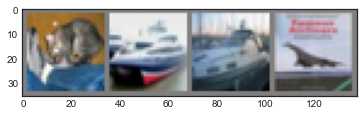

	cat 	ship 	ship 	plane


In [47]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

In [48]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

모델 테스트

In [49]:
outputs = net(images.to(device))

In [50]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	cat 	ship 	ship 	ship


In [51]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(100 * correct / total)

61.9


   - 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [52]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        C = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += C[i].item()
            class_total[label] += 1
for i in range(10):
    print("Accuracy of {}: {}%".format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 64.8%
Accuracy of car: 74.1%
Accuracy of bird: 37.5%
Accuracy of cat: 42.5%
Accuracy of deer: 62.1%
Accuracy of dog: 52.2%
Accuracy of flog: 64.0%
Accuracy of horse: 65.7%
Accuracy of ship: 80.6%
Accuracy of truck: 75.5%
